In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:


train=pd.read_csv("/kaggle/input/digit-recognizer/train.csv",index_col=False)
test=pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

**Gaining basic info**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
              label   pixel0   pixel1   pixel2   pixel3   pixel4   pixel5  \
count  42000.000000  42000.0  42000.0  42000.0  42000.0  42000.0  42000.0   
mean       4.456643      0.0      0.0      0.0      0.0      0.0      0.0   
std        2.887730      0.0      0.0      0.0      0.0      0.0      0.0   
min        0.000000      0.0      0.0      0.0      0.0      0.0      0.0   
25%        2.000000      0.0      0.0      0.0      0.0      0.0      0.0   
50%        4.000000      0.0      0.0      0.0      0.0      0.0      0.0   
75%        7.000000      0.0      0.0      0.0      0.0      0.0      0.0   
max        9.000000      0.0      0.0      0.0      0.0      0.0      0.0   

        pixel6   pixel7   pixel8  ...      pixel774      pixel775  \
count  42000.0  42000.0  42000.0  ...  42000.000000  42000.000000   
mean      

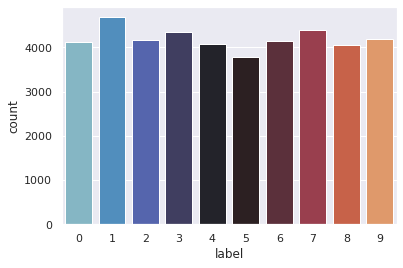

In [3]:
train.info()
print(train.describe())
print(train['label'].value_counts())
sns.countplot(train['label'],palette='icefire')

In [4]:
y=train['label'].copy()
train.drop("label",axis=1,inplace=True)


In [5]:
def missing_data_and_scaling(digit):
    from sklearn.impute import SimpleImputer
    imputer2 = SimpleImputer(strategy="median")

    imputer2.fit(digit)

    X = imputer2.transform(digit)  # Result is a plain Numpy array containing the transformed features
    digit_prepared = pd.DataFrame(X,columns=digit.columns, index=digit.index)  # Put it back into a Pandas DataFrame 
    from sklearn.preprocessing import StandardScaler
    scaled_features = StandardScaler().fit_transform(digit_prepared.values)
    scaled_digit=pd.DataFrame(scaled_features,index=digit_prepared.index,columns=digit_prepared.columns)
    return scaled_digit
X_scaled=missing_data_and_scaling(train)
print(X_scaled.head())
X_scaled.isnull().sum(axis = 0)

   pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   pixel9  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0     0.0  ... -0.034737  -0.02527 -0.018026 -0.011473 -0.009099 -0.006897   
1     0.0  ... -0.034737  -0.02527 -0.018026 -0.011473 -0.009099 -0.006897   
2     0.0  ... -0.034737  -0.02527 -0.018026 -0.011473 -0.009099 -0.006897   
3     0.0  ... -0.034737  -0.02527 -0.018026 -0.011473 -0.009099 -0.006897   
4     0.0  ... -0.034737  -0.02527 -0.018026 -0.011473 -0.009099 -0.006897   

   pixel780  pixel781  pixel782  pixel783  
0       0.0       0.0   

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

**Train test split**

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.4,test_size = 0.6, random_state = 101)


**Prepare the data for machine learning**

In [7]:
print('X_train shape:',X_train.shape)
print('y_train shape:',y_train.shape)
print('X_test shape:',X_test.shape)
print('y_test shape:',y_test.shape)

X_train shape: (16800, 784)
y_train shape: (16800,)
X_test shape: (25200, 784)
y_test shape: (25200,)


simpleimputer for missing data

                                     **Peformance measure step**

In [8]:
def cross_val(model,X_train,y_train,model_name):
    
    cross_val=cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
    print(model_name,' cv score:',cross_val)

def conf_matrix_precise_recall(y_test,y_pred,model_name):
    
    #conf_matrix
    print(metrics.confusion_matrix(y_true=y_test, y_pred=y_pred))
    
    # accuracy
    print("accuracy:", metrics.accuracy_score(y_true=y_test, y_pred=y_pred), "\n")
    
    #precision_score
    
    from sklearn.metrics import precision_score,recall_score    
    scores=metrics.classification_report(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    print(scores)

#This is for binary classification
    
# def roc(y_train,y_scores,model_name):
    
#     fpr, tpr, thresholds = roc_curve(y_train, y_scores)
#     plt.plot(fpr, tpr, linewidth=2, label=model_name)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.axis([0, 1, 0, 1])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.show()
    
#     print(model_name,' roc score:',roc_auc_score(y_train_5, y_scores))



                                      **Training classifier**

In [1]:
from sklearn.ensemble import RandomForestClassifier
forest_clf=RandomForestClassifier(random_state=42)
forest_clf.fit(X_train,y_train)

cross_val(forest_clf,X_train,y_train,'Randomforest')

y_pred=forest_clf.predict(X_test)
conf_matrix_precise_recall(y_test,y_pred,'Randomforest')
#0.95 This one has highest accuracy. we will go through it.
#############################################################
# from sklearn.neighbors import KNeighborsClassifier
# knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
# knn_clf.fit(X_train, y_train)

# cross_val(knn_clf,X_train,y_train,'KNNCLASSIIFER')

# y_pred=knn_clf.predict(X_test)
# conf_matrix_precise_recall(knn_clf,y_test,y_pred,'KNNclassifer')
#0.93
#####################################################################
# svc_clf=SVC(kernel='rbf')
# svc_clf.fit(X_train,y_train)

# cross_val(svc_clf,X_train,y_train,'SVC_rbf')

# y_pred=svc_clf.predict(X_test)
# conf_matrix_precise_recall(svc_clf,y_test,y_pred,'SVC_rbf')
# 0.949
##########################################################################
# from sklearn.linear_model import SGDClassifier
# sgd_clf = SGDClassifier(random_state=42)
# sgd_clf.fit(X_train,y_train)

# cross_val(sgd_clf,X_train,y_train,'SGD_classifier')

# y_pred=sgd_clf.predict(X_test)
# conf_matrix_precise_recall(sgd_clf,y_test,y_pred,'SGD_rbf')
# 0.91

NameError: name 'X_train' is not defined

                                      **FINE TUNE YOUR MODEL **

In [ ]:
param_grid = {
    'n_estimators': [100, 200,400,500],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 5,10,15],
    'min_samples_leaf' : [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(forest_clf, param_grid = param_grid, cv = 3, verbose = 5, n_jobs = -1)
grid.fit(X_train, y_train)

best_estimator = grid.best_estimator_

best_pred_y = best_estimator.predict(X_test)
conf_matrix_precise_recall(y_test,best_pred_y,'forest_with_cv')

                                **Error analysis**

In [ ]:
conf_mx = confusion_matrix(y_test, best_pred_y)
print(conf_mx)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
# fill the diagonal to zero for only showing the errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

here, the classes of 4/9,3/2,5/3 are missclassified. we can shift rotate them!
now this is called **Data augmentation**

In [12]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,best_pred_y)

0.9601190476190476

In [13]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)
X_train_expanded = [X_train]
y_train_expanded = [y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
print(X_train_expanded.shape, y_train_expanded.shape)




(84000, 784) (84000,)


In [14]:
forest_clf = RandomForestClassifier(**grid.best_params_)

forest_clf.fit(X_train_expanded, y_train_expanded)
y_pred = forest_clf.predict(X_test)
conf_matrix_precise_recall(y_test,y_pred,'forest_with_cv_augmented')

[[2446    0    0    0    4    1   10    1   16    0]
 [   0 2776   10   10    7    4    1    4    7    3]
 [  10    3 2447    6    8    0    9   30   12    2]
 [   2    4   29 2470    1   24    5   19   23   14]
 [   4    1    3    0 2401    0   10    3    5   36]
 [   7    2    1   20    4 2186   12    1   10   12]
 [   9    2    2    0    1   11 2426    0    9    0]
 [   1   10   25    3    8    0    0 2527    4   28]
 [   9    7    8   12   11   12    6    3 2374   23]
 [  12    4    5   25   24    4    2   22   15 2420]]
accuracy: 0.9711507936507936 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2478
           1       0.99      0.98      0.99      2822
           2       0.97      0.97      0.97      2527
           3       0.97      0.95      0.96      2591
           4       0.97      0.97      0.97      2463
           5       0.98      0.97      0.97      2255
           6       0.98      0.99      0.98      2460
     

evaluating on test set

In [15]:
test_scaled=missing_data_and_scaling(test)
test_scaled.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.030075,-0.020243,-0.015459,-0.009335,-0.008094,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.030075,-0.020243,-0.015459,-0.009335,-0.008094,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.030075,-0.020243,-0.015459,-0.009335,-0.008094,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.030075,-0.020243,-0.015459,-0.009335,-0.008094,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.030075,-0.020243,-0.015459,-0.009335,-0.008094,0.0,0.0,0.0,0.0,0.0


In [16]:
y_test_pred = forest_clf.predict(test_scaled)


In [17]:
index=list(test.index)
d={'ImageId':index,
   'Label':y_test_pred}

df1=pd.DataFrame(d)
df1.to_csv("digit_classification_rnadomforest.csv",index=False)